# 03 switch activation

Within the following tutorial you are going to see how the activation of the switches works.

### Input description

The input for the graph construction currently consists of text files reflecting the hierarchy of the plant elements and their features. In the text input files each line corresponds to a node/element description.
The same line reports the name of the predecessor of a particular node/element, the relationship between them, and the list of node’s attributes (area in which the element is 
present, perturbation resistance, etc.).
In this way each line corresponds to an edge connecting a element to its parent element.

Each line should contain the following info:
- element id (**mark**)
- parent-child relationship (**father_condition**: *AND*, *OR*, *SINGLE*, *ORPHAN*. It is an edge attribute.)
- id of the parent of the element (**father_mark**)
- area in which the element is located (**area**. It is a node attribute.)
- passive perturbation resistance (**perturbation_resistant**: *1*, *0*. It is a node attribute.)
- state of the SWITCH(es) (**init_status**: *1*, *0*. It is a node attribute.)
- description of the element (**description**. It is a node attribute.)
- source - hub - switch- user elements (**type**: *SOURCE* or *HUB* or *SWITCH* or *USER*. It is a node attribute.)
- weight of the edge between element and parent (**weight**: float number. It is an edge attribute.)
- initial service at the sources (**initial_service**. It is a node attribute, for the moment valid just for sources, and 0. for other nodes. It is a node attribute.)

The hierarchy of the elements explains how commodities flow from one element to another element and from one system to another system. In fact, if the input is properly formatted, with this simple digraph model it is possible to represent and integrate different interconnected plants in a unique graph without losing information about their peculiarities. 

In the graph, the nodes represent the system elements while the edges connecting the nodes harbor the logic relations (edge attributes) existing between the elements (*ORPHAN*, *SINGLE*, *AND*, and *OR*):
- An **ORPHAN** edge is the edge of a node without predecessors.
- A **SINGLE** edge connects a node to its only one predecessor.
- An **AND** edge indicates that the node/element has more than one predecessor. All the predecessors are necessary for the functioning of that element.
- An **OR** edge indicates that the node/element has more than one predecessor. Just one of the node’s predecessors should be active to guarantee the functioning of the element. For this reason, correct input formatting is one of the most important steps of the analysis.

### The switch line graph

In [1]:
import pandas as pd
from grape.general_graph import GeneralGraph
from grape.fault_diagnosis import FaultDiagnosis
%matplotlib inline

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


First of all, let us define a FaultDiagnosis variable and load the nodes for graph from the input file.

In [2]:
F = FaultDiagnosis("./input_files/switch_line.csv")

Let's have a look at the graph we are going to study.

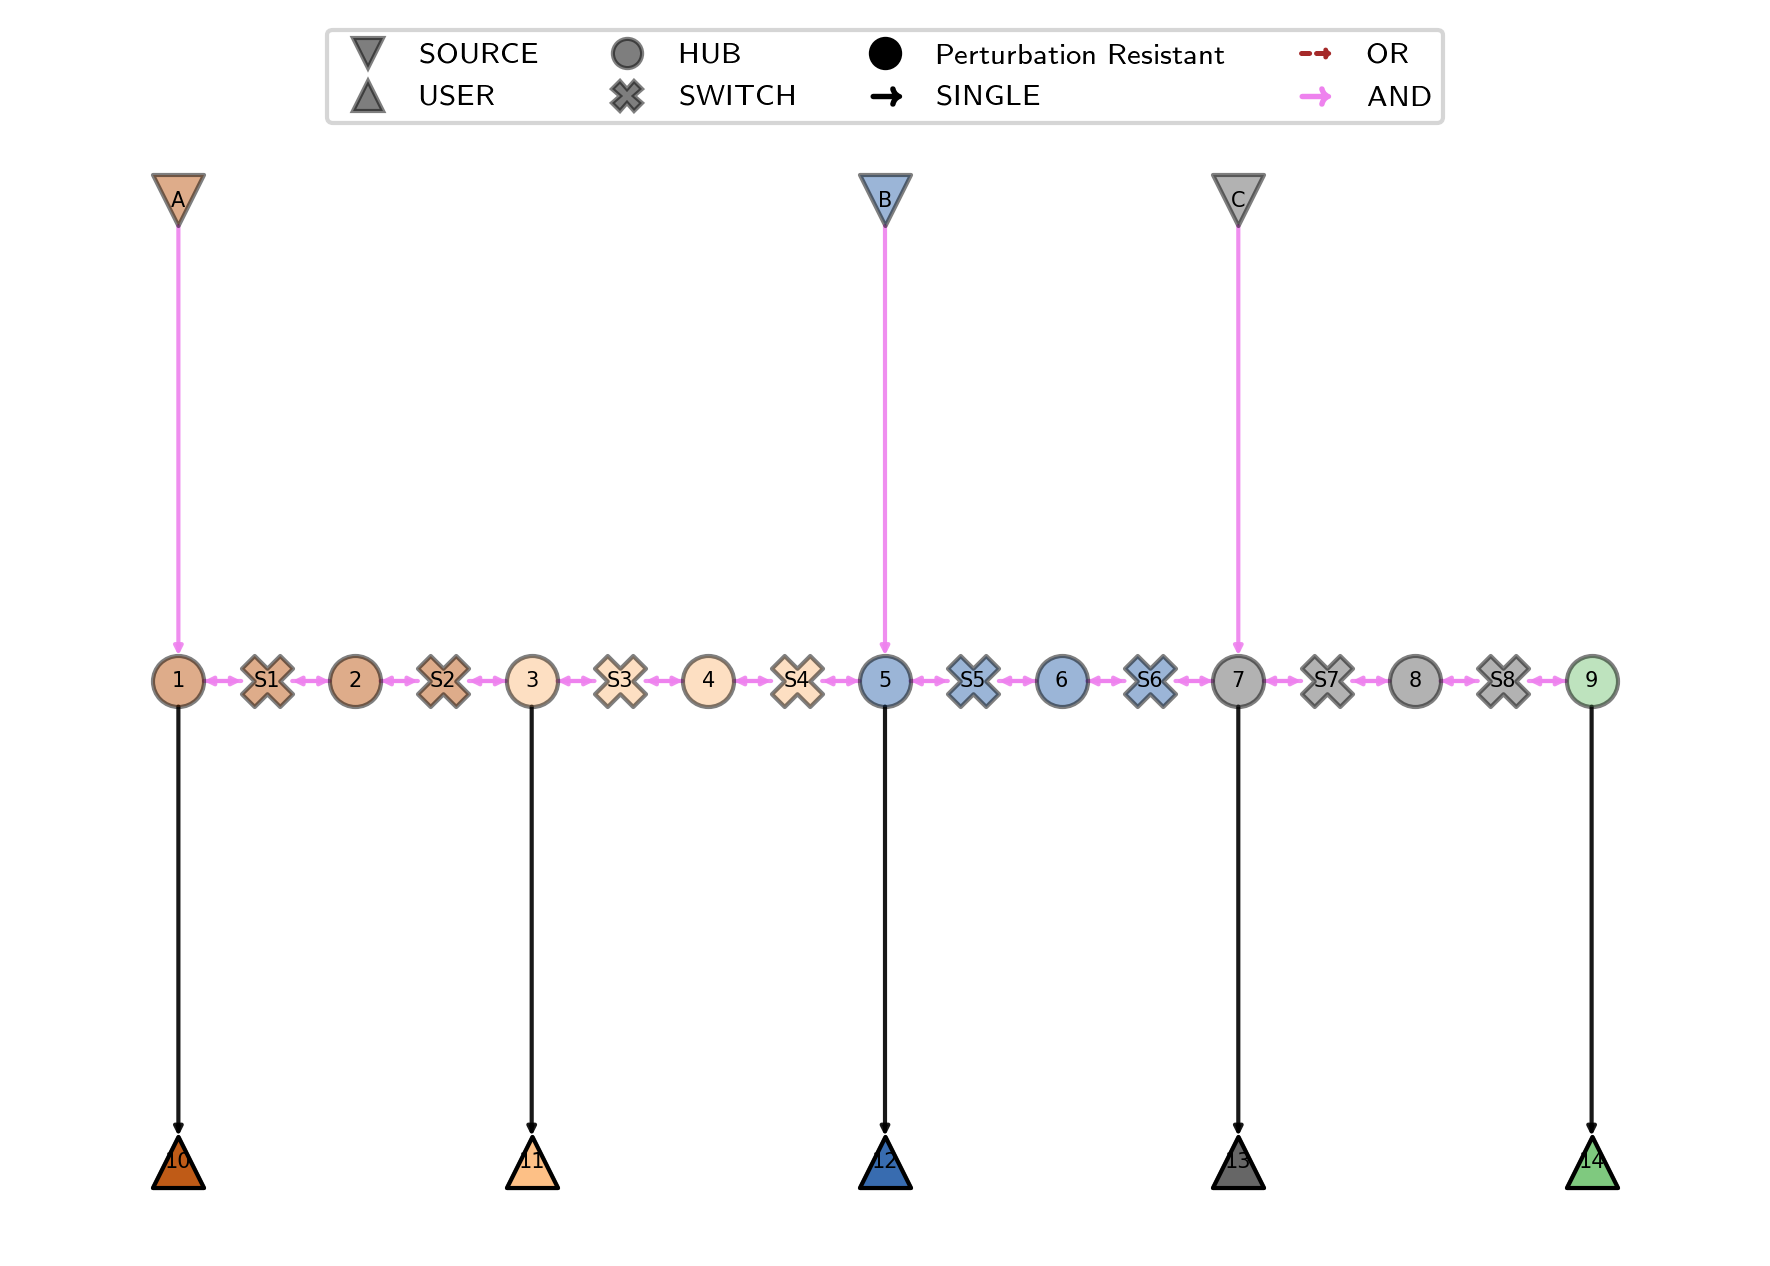

{'10': array([0., 0.]),
 '1': array([0., 2.]),
 '11': array([8., 0.]),
 '3': array([8., 2.]),
 '12': array([16.,  0.]),
 '5': array([16.,  2.]),
 '13': array([24.,  0.]),
 '7': array([24.,  2.]),
 '14': array([32.,  0.]),
 '9': array([32.,  2.]),
 'A': array([0., 4.]),
 'S1': array([2., 2.]),
 '2': array([4., 2.]),
 'S2': array([6., 2.]),
 'S3': array([10.,  2.]),
 '4': array([12.,  2.]),
 'S4': array([14.,  2.]),
 'B': array([16.,  4.]),
 'S5': array([18.,  2.]),
 '6': array([20.,  2.]),
 'S6': array([22.,  2.]),
 'C': array([24.,  4.]),
 'S7': array([26.,  2.]),
 '8': array([28.,  2.]),
 'S8': array([30.,  2.])}

In [3]:
import matplotlib as mpl
dpi = 300
mpl.rcParams['figure.dpi']= dpi
import math

initial = {'10': (0., 0.), '1': (0., 2.), 'A': (0., 4.),
    'S1': (2., 2.), '2': (4., 2.), 'S2': (6., 2.), '3': (8., 2.),
    '11': (8., 0.), 'S3': (10., 2.), '4': (12., 2.), 'S4': (14., 2.),
    '5': (16., 2.), '12': (16., 0.), 'B': (16., 4.), 'S5': (18., 2.),
    '6': (20., 2.), 'S6': (22., 2.), '7': (24., 2.), '13': (24., 0.),
    'C': (24., 4.), 'S7': (26., 2.), '8': (28., 2.), 'S8': (30., 2.),
    '9': (32., 2.), '14': (32., 0.)}

F.G.print_graph(initial_pos=initial, size=150, arrow_size=4, fsize=5, fixed_nodes=list(F.G),
                title='Switch line (integer)', input_cmap='Accent', legend_loc='upper center',
                legend_ncol=4, legend_anchor=(0.5, 1.1), legend_fsize=7)

In the figure above it is represented the example input file `switch_line.csv`.
The graph contains 25 elements connected by direct edges that reflect the hierarchy of the system in a parent-child fashion.

The nodes are distributed in adjacent areas, which have been depicted with different colors specifying the `input_cmap` argument of `print_graph function`.

In area1 are present 6 nodes: A, 1, S<sub>1</sub>, 2, S<sub>2</sub>, and 10.

In area2 are present 5 nodes: 3, S<sub>3</sub>, 4, S<sub>4</sub>, and 11.

In area3 are present 6 nodes: B, 5, S<sub>5</sub>, 6, S<sub>6</sub> and 12.

In area4 are present 6 nodes: C, 7, S<sub>7</sub>, 8, S<sub>8</sub> and 13.

In area5 are present 2 nodes: 9, and 14.

A perturbation of one or multiple elements in one area may exceed the area boundaries and propagate to other systems connected to it, located in other areas. 

Nodes 10, 11, 12, 13, 14 are perturbation resistant nodes (`perturbation_resistant` field = 1). These nodes will not be affected by the simulated perturbation. The resistance is specified by the red border of these nodes.

Nodes S<sub>1</sub>, S<sub>2</sub>, S<sub>3</sub>, S<sub>4</sub>, S<sub>5</sub>, S<sub>6</sub>, S<sub>7</sub> and S<sub>8</sub> are isolating elements (they are a particular type of `HUB` nodes, called `SWITCH`).

### Switch activation
`SWITCH` nodes are a particular kind of `HUB` nodes. Their activation can stop the propagation of a fault in a graph, avoiding a very dangerous cascade effect. Differently from the `perturbation_resistant` nodes, which represent a passive resistance which does not need to be activated, these nodes are characterized by two possible values: `True` or `False`. The choice between the two values is made thanks to a genetic algorithm procedure.

A genetic algorithm generates a population of individuals with random genes, and makes them evolve mimicking Darwin’s theory of evolution:
- *Selection*: the best individuals of the previous generation are chosen to breed the new one, according to their fitnesses
- *Crossover*: combine the genetic information of two parents to create a new offspring
- *Mutation*: individuals evolve by changing part of their genes

Iterating this process for a certain number of times (generations), it is possible to optimize the original population.

In order to implement our genetic algorithm we used [DEAP (Distributed Evolutionary Algorithms in Python)](https://github.com/deap/deap).

#### Switch state
The first concept that we need, to describe how the genetic algorithm works, is the concept of *state*: a *state* for `GRAPE` is defined as a list of values for all the switches present in the graph. There can be many different combinations of values for the switches, each one identifying a different *state*. In the following figure you can see one of the possible realizations for S<sub>1, ..., 8</sub>:

<img src="./input_files/switch_state.png" alt="switch_state" width="400" height="300"/>

#### Switch fitness
Every *state* of the switches is accompanied by a certain quantity, defined *fitness*, that gives us information on how much the configuration is genetically favourable. In GRAPE, we define the best *state* as the one that minimizes the fitness. Three main quantities constitute the fitness evaluation:
- *number of actions*: this quantity expresses the number of flips (in terms of changes from `True` to `False` or vice-versa) that need to be made with respect to the initial condition for the switches, in order to obtain the concerned configuration
- *total final service at USERs*: the sum of the total final service
- *final graph size*: the total number of surviving nodes after the perturbation, for that given configuration of switches

These three quantities can be weighted in different ways, specifying a their multiplicative coefficients. For this tutorial, we choose $w_1 = w_2 = w_3 = 1.0$. In this way, the final fitness is easily given by: $(# actions) - (total final service) - (final graph size)$.

### Simulate a perturbation

#### Initial condition
We are now going to simulate different possible kinds of perturbations for the graph described in the input file `switch_line.csv`. For every one of them, we are going to comment about the best configuration for the switches.

Let us check the input before perturbing the graph in any way. In order to do so we use `check_input_with_gephi` function, which prints out the list of edges and the list of nodes of the current graph. The two output files generated can be used to visualize the input with Gephi.

In [4]:
F.check_input_with_gephi()

Let us have a look at the list of nodes and edges that get printed for the graph, before the occurrence of any perturbation.

In [5]:
nodes = pd.read_csv("check_import_nodes.csv", na_filter=False)
nodes

,mark,description,init_status,perturbation_resistant,area
0,10,,,1,area1
1,11,,,1,area2
2,12,,,1,area3
3,13,,,1,area4
4,14,,,1,area5
5,1,,,0,area1
6,S1,,1,0,area1
7,2,,,0,area1
8,S2,,1,0,area1
9,3,,,0,area2


In [6]:
edges = pd.read_csv("check_import_edges.csv", na_filter=False)
edges

,mark,father_mark
0,10,1
1,11,3
2,12,5
3,13,7
4,14,9
5,1,A
6,1,S1
7,S1,1
8,S1,2
9,2,S1


From the report of the nodes in the `check_import_nodes.csv` file, we can extract a very important information, namely the initial condition for the switches. In the present case, all of them are initially set to 'True', so our initial condition looks like the following:

<img src="./input_files/switch_state_alltrue.png" alt="switch_state_alltrue" width="400" height="300"/>

#### Perturbation of node "1"

We are going to use the function `simulate_element_perturbation`, which takes as an argument the list of the nodes that we want to damage.

In [7]:
F.simulate_element_perturbation(["1"])

DEBUG:root:In the graph are present 25 nodes
DEBUG:root:The graph is dense, density = 0.06666666666666667
DEBUG:root:Switch S1 finally open, first closed

BEST: {'S1': False, 'S2': True, 'S3': True, 'S4': True, 'S5': True, 'S6': True, 'S7': True, 'S8': True}
# of actions: 1
Total final service: 2.0
# of survived nodes: 24
Fitness: -25.0
DEBUG:root:Visited: {'1'}
DEBUG:root:Node: 1
DEBUG:root:Predecessors: ['A', 'S1']
DEBUG:root:Broken: ['1']
DEBUG:root:Visited: {'1', '10'}
DEBUG:root:Node: 10
DEBUG:root:Node 10 visited, fault resistant node
DEBUG:root:In the graph are present 24 nodes
DEBUG:root:The graph is dense, density = 0.06340579710144928


The execution of the perturbation of element "1" gives us information about what is going on. The size of the integer graph is reported (25 nodes).

The debug output gives us an idea of what happens. Node "1" has no fault resistance of any kind; hence, it gets broken. After that, the perturbation could in principle propagate to all nodes (if not limited), but the genetic algorithm identifies the following best state: all the switches but S<sub>1</sub> remain `True` (hence, closed). This configuration has the following characteristics in terms of *fitness*:
- 1 action with respect to the initial condition
- 2.0 total final service
- 24 nodes surviving to the perturbation

The final fitness is, then: $1 - 2 - 24 = -25$.

The activation of one switch cuts off the edges between the switch and *all* its predecessors. We can see that inspecting the graph.

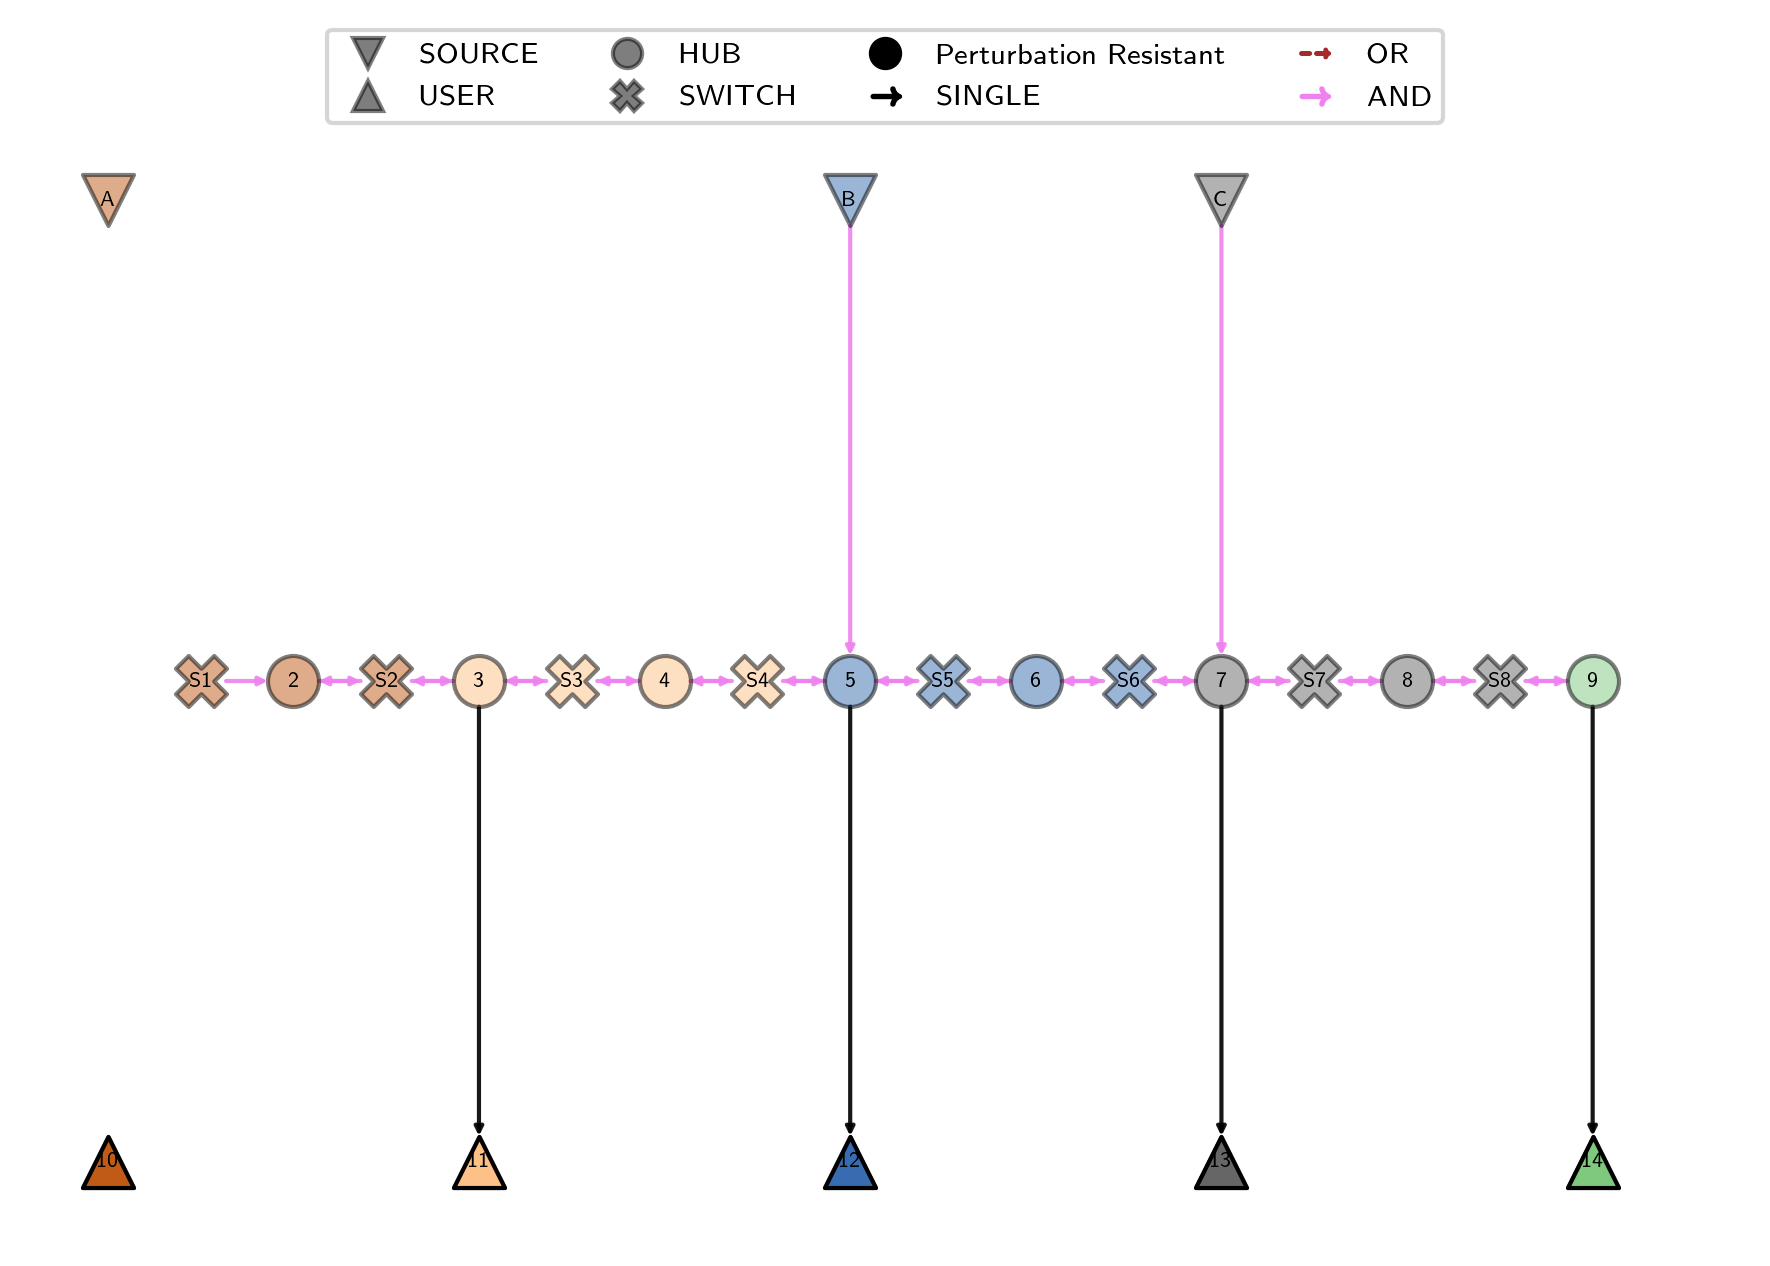

{'10': array([0., 0.]),
 '11': array([8., 0.]),
 '3': array([8., 2.]),
 '12': array([16.,  0.]),
 '5': array([16.,  2.]),
 '13': array([24.,  0.]),
 '7': array([24.,  2.]),
 '14': array([32.,  0.]),
 '9': array([32.,  2.]),
 'A': array([0., 4.]),
 'S1': array([2., 2.]),
 '2': array([4., 2.]),
 'S2': array([6., 2.]),
 'S3': array([10.,  2.]),
 '4': array([12.,  2.]),
 'S4': array([14.,  2.]),
 'B': array([16.,  4.]),
 'S5': array([18.,  2.]),
 '6': array([20.,  2.]),
 'S6': array([22.,  2.]),
 'C': array([24.,  4.]),
 'S7': array([26.,  2.]),
 '8': array([28.,  2.]),
 'S8': array([30.,  2.])}

In [8]:
F.G.print_graph(initial_pos=initial, size=150, arrow_size=4, fsize=5, fixed_nodes=list(F.G),
                title='Switch line (node 1 perturbed)', input_cmap='Accent', legend_loc='upper center',
                legend_ncol=4, legend_anchor=(0.5, 1.1), legend_fsize=7)

In [9]:
print("\nPredecessors of S1: ", list(F.G.predecessors('S1')))
print("\nSuccessors of S1: ", list(F.G.successors('S1')))


Predecessors of S1:  []

Successors of S1:  ['2']


#### Perturbation of node "2"

We are going to use the function `simulate_element_perturbation`, which takes as an argument the list of the nodes that we want to damage. This time, we perturb again a single node, namely node "2"; however, this node is surrounded by more switches.

In [10]:
D = FaultDiagnosis("./input_files/switch_line.csv")
D.simulate_element_perturbation(["2"])

/u/m/mteruzzi/miniconda/envs/test/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/u/m/mteruzzi/miniconda/envs/test/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


DEBUG:root:In the graph are present 25 nodes
DEBUG:root:The graph is dense, density = 0.06666666666666667
DEBUG:root:Switch S1 finally open, first closed
DEBUG:root:Switch S2 finally open, first closed

BEST: {'S1': False, 'S2': False, 'S3': True, 'S4': True, 'S5': True, 'S6': True, 'S7': True, 'S8': True}
# of actions: 2
Total final service: 3.0
# of survived nodes: 24
Fitness: -25.0
DEBUG:root:Visited: {'2'}
DEBUG:root:Node: 2
DEBUG:root:Predecessors: ['S1', 'S2']
DEBUG:root:Broken: ['2']
DEBUG:root:In the graph are present 24 nodes
DEBUG:root:The graph is dense, density = 0.06159420289855073


This time, in order to isolate the broken node, we need to open two switches: both S<sub>1</sub> and S<sub>2</sub> get activated. The fitness of the best state can be computed like: $2 - 3 - 24 = -25$. It is important to notice that opening S<sub>1</sub> and S<sub>2</sub> has indeed modified the flow in the graph. In fact, the final service is still equal to $3$, but differently distributed within the USERs with respect to the original one. While initially all the USERs were evenly receiving $1/5$ of the total service, the final situation looks like the following:

In [11]:
element = pd.read_csv("element_perturbation.csv", na_filter=False)
element[['mark', 'original_service', 'final_service']].loc[0:4]

,mark,original_service,final_service
0,10,0.6,1.0
1,11,0.6,0.5
2,12,0.6,0.5
3,13,0.6,0.5
4,14,0.6,0.5


Finally, in fact, just the USER "10" is connected to SOURCE "A", receiving all its service. Regarding SOURCEs "B" and "C", instead, the sum of their service is evenly split between "11", "12, "13" and "14". As before, we can inspect the final situation looking at the graph.

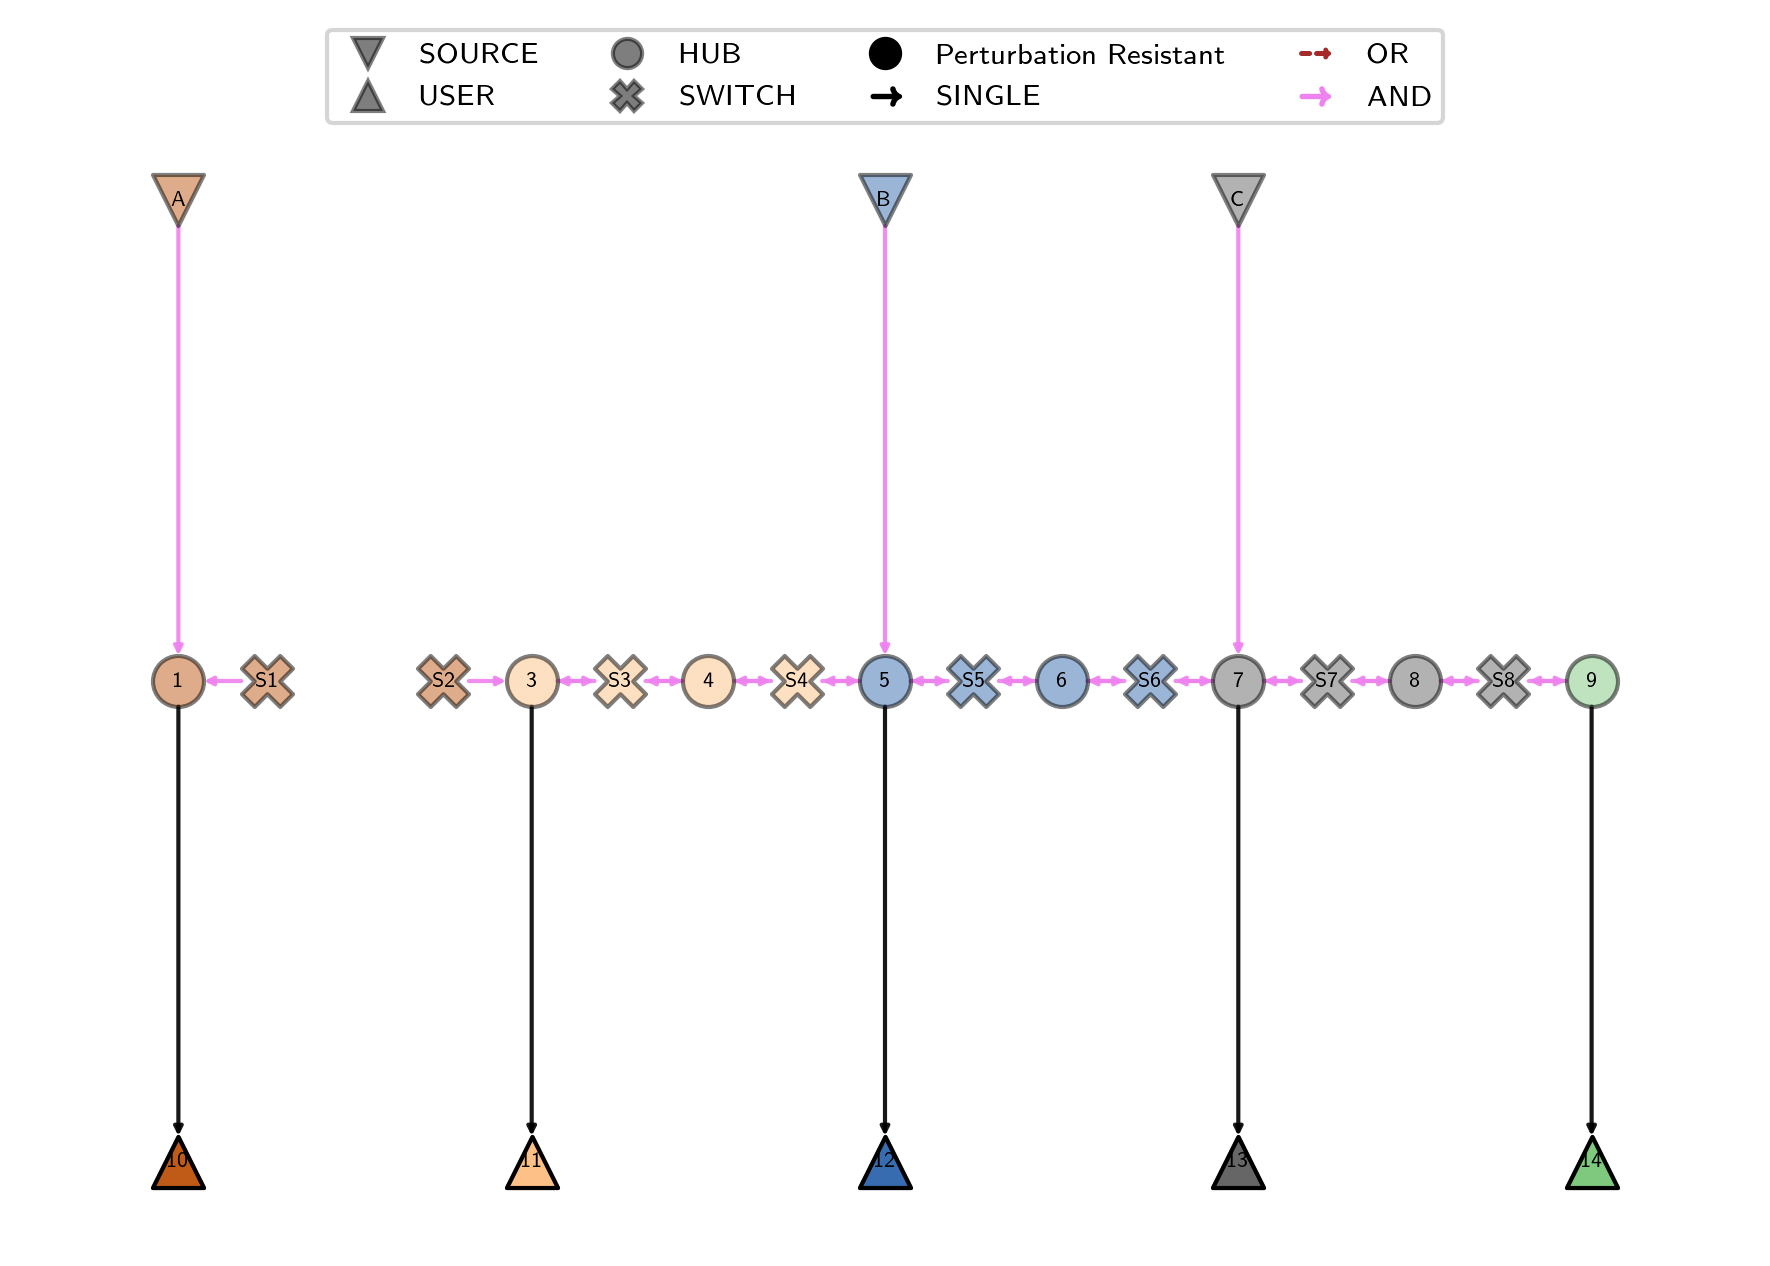

{'10': array([0., 0.]),
 '1': array([0., 2.]),
 '11': array([8., 0.]),
 '3': array([8., 2.]),
 '12': array([16.,  0.]),
 '5': array([16.,  2.]),
 '13': array([24.,  0.]),
 '7': array([24.,  2.]),
 '14': array([32.,  0.]),
 '9': array([32.,  2.]),
 'A': array([0., 4.]),
 'S1': array([2., 2.]),
 'S2': array([6., 2.]),
 'S3': array([10.,  2.]),
 '4': array([12.,  2.]),
 'S4': array([14.,  2.]),
 'B': array([16.,  4.]),
 'S5': array([18.,  2.]),
 '6': array([20.,  2.]),
 'S6': array([22.,  2.]),
 'C': array([24.,  4.]),
 'S7': array([26.,  2.]),
 '8': array([28.,  2.]),
 'S8': array([30.,  2.])}

In [12]:
D.G.print_graph(initial_pos=initial, size=150, arrow_size=4, fsize=5, fixed_nodes=list(D.G),
                title='Switch line (node 2)', input_cmap='Accent', legend_loc='upper center',
                legend_ncol=4, legend_anchor=(0.5, 1.1), legend_fsize=7)

#### Perturbation of node "2" and "3"

We are going to use the function `simulate_element_perturbation`, which takes as an argument the list of the nodes that we want to damage. This time, we perturb more than one node, namely node "2" and "3".

In [13]:
T = FaultDiagnosis("./input_files/switch_line.csv")
T.simulate_element_perturbation(["2", "3"])

/u/m/mteruzzi/miniconda/envs/test/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/u/m/mteruzzi/miniconda/envs/test/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


DEBUG:root:In the graph are present 25 nodes
DEBUG:root:The graph is dense, density = 0.06666666666666667
DEBUG:root:Switch S1 finally open, first closed
DEBUG:root:Switch S3 finally open, first closed

BEST: {'S1': False, 'S2': True, 'S3': False, 'S4': True, 'S5': True, 'S6': True, 'S7': True, 'S8': True}
# of actions: 2
Total final service: 2.9999999999999996
# of survived nodes: 22
Fitness: -23.0
DEBUG:root:Visited: {'2'}
DEBUG:root:Node: 2
DEBUG:root:Predecessors: ['S1', 'S2']
DEBUG:root:Broken: ['2']
DEBUG:root:Visited: {'S2', '2'}
DEBUG:root:Node: S2
DEBUG:root:Predecessors: ['2', '3']
DEBUG:root:Broken S2, AND predecessor broken.
DEBUG:root:Nodes broken so far: ['2', 'S2']
DEBUG:root:Visited: {'S2', '3', '2'}
DEBUG:root:Node: 3
DEBUG:root:Predecessors: ['S2', 'S3']
DEBUG:root:Broken 3, AND predecessor broken.
DEBUG:root:Nodes broken so far: ['2', 'S2', '3']
DEBUG:root:Visited: {'11', 'S2', '3', '2'}
DEBUG:root:Node: 11
DEBUG:root:Node 11 visited, fault resistant node
DEBUG:root:

This type of perturbation is particularly interesting since it allows us to underline the case in which two states have the same fitness. The states in this case are:
- $\{S_1: False, S_2: False, S_3: False, S_4: True, S_5: True, S_6: True, S_7: True, S_8: True\}$, with fitness: $3 - 3 - 23 = -23$
- $\{S_1: False, S_2: True, S_3: False, S_4: True, S_5: True, S_6: True, S_7: True, S_8: True\}$, with fitness: $2 - 3 - 22 = -23$.

In this case, both outcomes are possible as best final states. In order to make one final state with respect to another,the weights $\{w_1, w_2, w_3\}$ for the fitness evaluation can be specified.

As usual, we inspect the final configuration of the graph printing it.

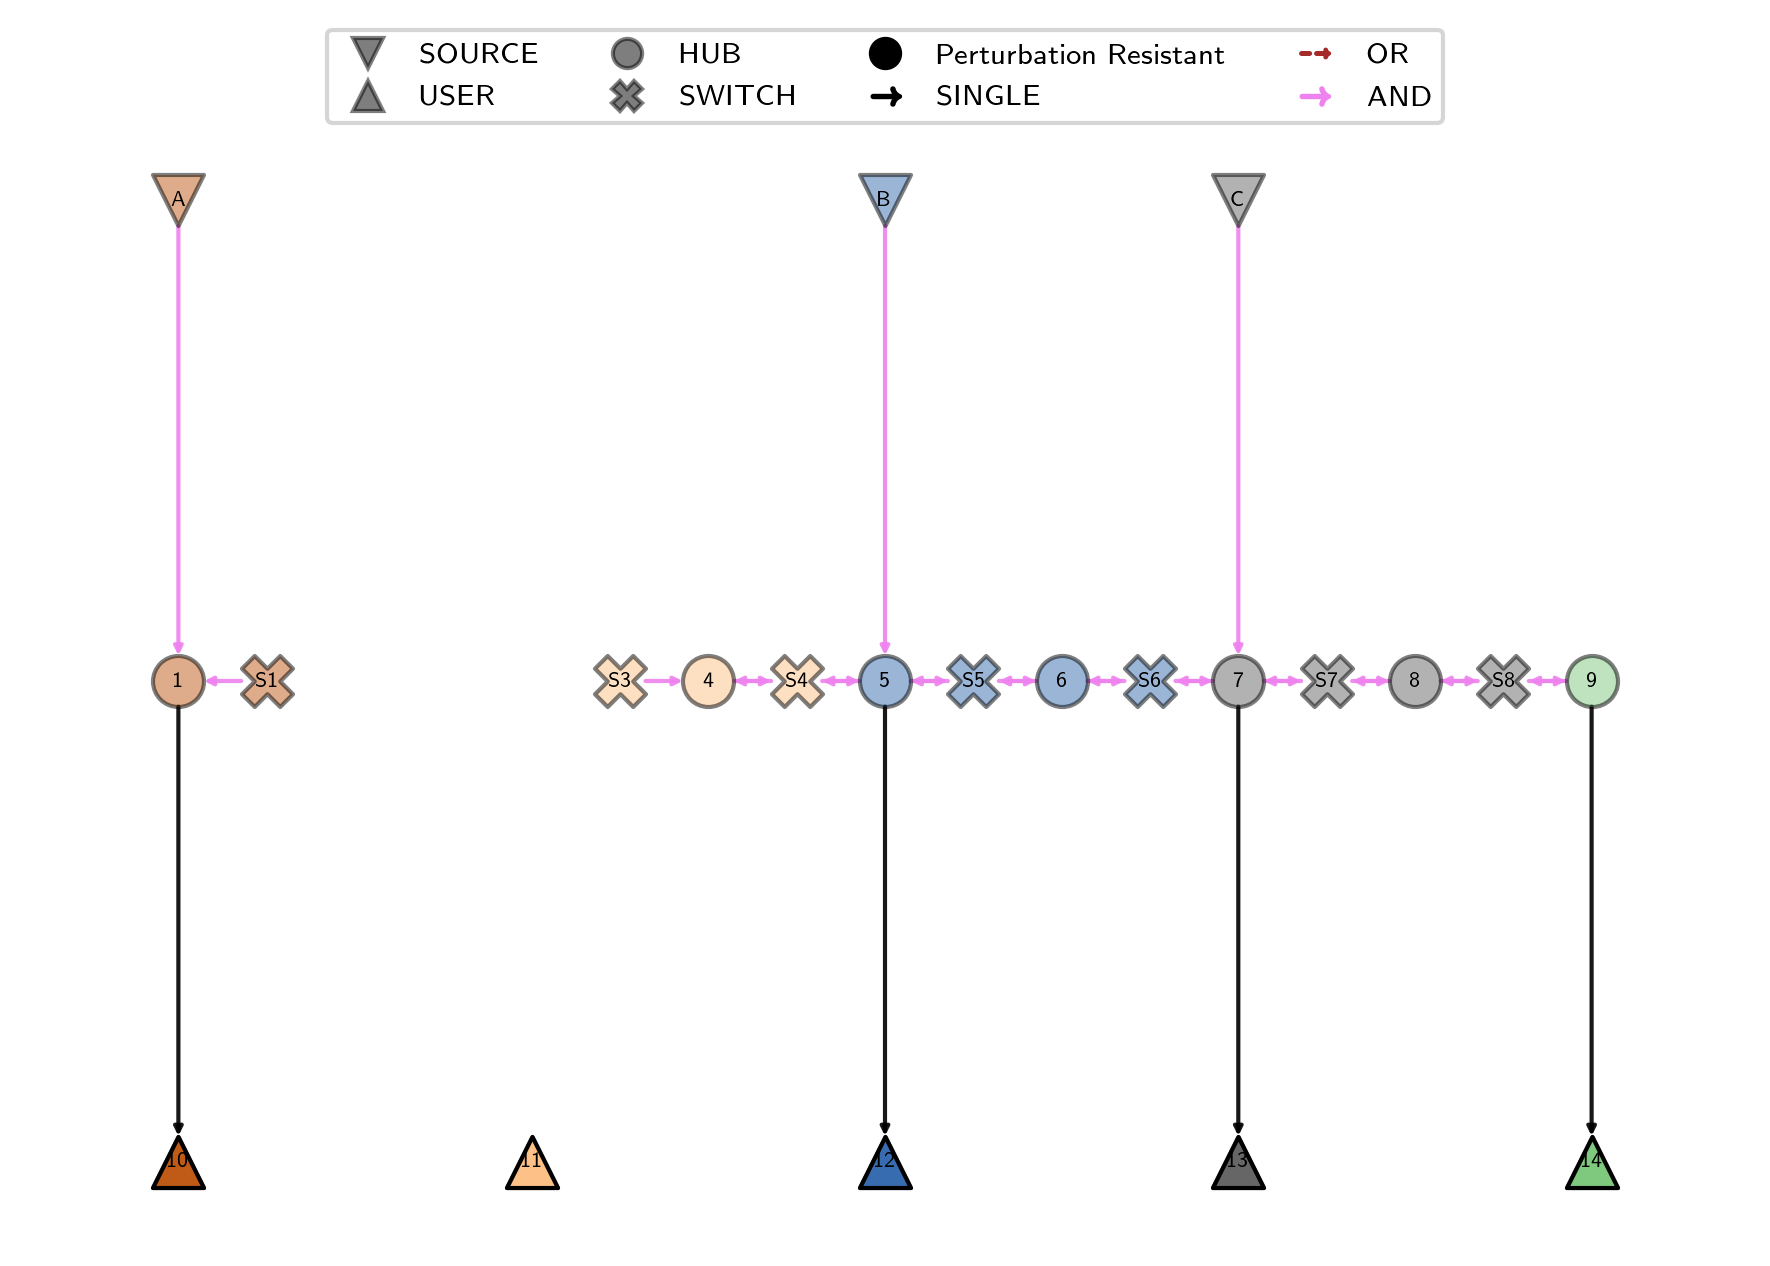

{'10': array([0., 0.]),
 '1': array([0., 2.]),
 '11': array([8., 0.]),
 '12': array([16.,  0.]),
 '5': array([16.,  2.]),
 '13': array([24.,  0.]),
 '7': array([24.,  2.]),
 '14': array([32.,  0.]),
 '9': array([32.,  2.]),
 'A': array([0., 4.]),
 'S1': array([2., 2.]),
 'S3': array([10.,  2.]),
 '4': array([12.,  2.]),
 'S4': array([14.,  2.]),
 'B': array([16.,  4.]),
 'S5': array([18.,  2.]),
 '6': array([20.,  2.]),
 'S6': array([22.,  2.]),
 'C': array([24.,  4.]),
 'S7': array([26.,  2.]),
 '8': array([28.,  2.]),
 'S8': array([30.,  2.])}

In [14]:
T.G.print_graph(initial_pos=initial, size=150, arrow_size=4, fsize=5, fixed_nodes=list(T.G),
                title='Switch line (nodes 2 and 3 perturbed)', input_cmap='Accent', legend_loc='upper center',
                legend_ncol=4, legend_anchor=(0.5, 1.1), legend_fsize=7)